## WGAN

In [1]:
import os
import tensorflow as tf
import tensorflow.keras.backend as K
K.set_image_data_format('channels_first')
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, ZeroPadding2D, BatchNormalization, Input, Dropout
from tensorflow.keras.layers import Conv2DTranspose, Reshape, Activation, Cropping2D, Flatten
from tensorflow.keras.activations import relu
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.initializers import RandomNormal
conv_init = RandomNormal(0, 0.02)
gamma_init = RandomNormal(1., 0.02)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [11]:
def DCGAN_D(isize, nz, nc, ndf, n_extra_layers=0):
    assert isize%2==0
    _ = inputs = Input(shape=(nc, isize, isize))
    _ = Conv2D(filters=ndf, kernel_size=4, strides=2, use_bias=False,
                        padding = "same",
                        kernel_initializer = conv_init, 
                        name = 'initial.conv.{0}-{1}'.format(nc, ndf)             
                        ) (_)
    # _ = Dropout(0.5)(_)
    _ = LeakyReLU(alpha=0.2, name = 'initial.relu.{0}'.format(ndf))(_)
    csize, cndf = isize// 2, ndf
    while csize > 5:
        assert csize%2==0
        in_feat = cndf
        out_feat = cndf*2
        _ = Conv2D(filters=ndf, kernel_size=4, strides=2, use_bias=False,
                        padding = "same",
                        kernel_initializer = conv_init,
                        name = 'pyramid.{0}-{1}.conv'.format(in_feat, out_feat)             
                        ) (_)
        # _ = Dropout(0.5)(_)
        if 0: # toggle batchnormalization
            _ = BatchNormalization(name = 'pyramid.{0}.batchnorm'.format(out_feat),                                   
                                   momentum=0.9, axis=1, epsilon=1.01e-5,
                                   gamma_initializer = gamma_init, 
                                  )(_, training=1)       
        _ = LeakyReLU(alpha=0.2, name = 'pyramid.{0}.relu'.format(out_feat))(_)
        csize, cndf = (csize+1)//2, cndf*2
    _ = Conv2D(filters=1, kernel_size=csize, strides=1, use_bias=False,
                        kernel_initializer = conv_init,
                        name = 'final.{0}-{1}.conv'.format(cndf, 1)         
                        ) (_)
    outputs = Flatten()(_)
    return Model(inputs=inputs, outputs=outputs)

In [12]:
def DCGAN_G(isize, nz, nc, ngf, n_extra_layers=0):
    cngf= ngf//2
    tisize = isize
    while tisize > 5:
        cngf = cngf * 2
        assert tisize%2==0
        tisize = tisize // 2
    _ = inputs = Input(shape=(nz,))
    _ = Reshape((nz, 1,1))(_)
    _ = Conv2DTranspose(filters=ngf, kernel_size=tisize, strides=1, use_bias=False,
                           kernel_initializer = conv_init, 
                           name = 'initial.{0}-{1}.convt'.format(nz, cngf))(_)
    # _ = Dropout(0.5)(_)
    _ = BatchNormalization(gamma_initializer = gamma_init, momentum=0.9, axis=1, epsilon=1.01e-5,
                               name = 'initial.{0}.batchnorm'.format(cngf))(_, training=1)
    _ = Activation("relu", name = 'initial.{0}.relu'.format(cngf))(_)
    csize, cndf = tisize, cngf
    

    while csize < isize//2:
        in_feat = cngf
        out_feat = cngf//2
        _ = Conv2DTranspose(filters=ngf, kernel_size=4, strides=2, use_bias=False,
                        kernel_initializer = conv_init, padding="same",
                        name = 'pyramid.{0}-{1}.convt'.format(in_feat, out_feat)             
                        ) (_)
        # _ = Dropout(0.5)(_)
        _ = BatchNormalization(gamma_initializer = gamma_init, 
                                   momentum=0.9, axis=1, epsilon=1.01e-5,
                                   name = 'pyramid.{0}.batchnorm'.format(out_feat))(_, training=1)
        
        _ = Activation("relu", name = 'pyramid.{0}.relu'.format(out_feat))(_)
        csize, cngf = csize*2, cngf//2
    _ = Conv2DTranspose(filters=nc, kernel_size=4, strides=2, use_bias=False,
                        kernel_initializer = conv_init, padding="same",
                        name = 'final.{0}-{1}.convt'.format(cngf, nc)
                        )(_)
    outputs = Activation("tanh", name = 'final.{0}.tanh'.format(nc))(_)
    return Model(inputs=inputs, outputs=outputs)

In [13]:
# parameters
nc = 3 # channel
nz = 500 # dimension
ngf = 128 # number of G filter
ndf = 128 # number of D filter
n_extra_layers = 0
Diters = 5
λ = 10

imageSize = 32
batchSize = 64
lrD = 1e-4
lrG = 1e-4

In [14]:
netD = DCGAN_D(imageSize, nz, nc, ndf, n_extra_layers)
netD.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 3, 32, 32)]       0         
_________________________________________________________________
initial.conv.3-128 (Conv2D)  (None, 128, 16, 16)       6144      
_________________________________________________________________
initial.relu.128 (LeakyReLU) (None, 128, 16, 16)       0         
_________________________________________________________________
pyramid.128-256.conv (Conv2D (None, 128, 8, 8)         262144    
_________________________________________________________________
pyramid.256.relu (LeakyReLU) (None, 128, 8, 8)         0         
_________________________________________________________________
pyramid.256-512.conv (Conv2D (None, 128, 4, 4)         262144    
_________________________________________________________________
pyramid.512.relu (LeakyReLU) (None, 128, 4, 4)         0   

In [15]:
netG = DCGAN_G(imageSize, nz, nc, ngf, n_extra_layers)
netG.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 500, 1, 1)         0         
_________________________________________________________________
initial.500-512.convt (Conv2 (None, 128, 4, 4)         1024000   
_________________________________________________________________
initial.512.batchnorm (Batch (None, 128, 4, 4)         512       
_________________________________________________________________
initial.512.relu (Activation (None, 128, 4, 4)         0         
_________________________________________________________________
pyramid.512-256.convt (Conv2 (None, 128, 8, 8)         262144    
_________________________________________________________________
pyramid.256.batchnorm (Batch (None, 128, 8, 8)         512 

In [16]:
from tensorflow.keras.optimizers import RMSprop, SGD, Adam

In [17]:
netD_real_input = Input(shape=(nc, imageSize, imageSize))
noisev = Input(shape=(nz,))
netD_fake_input = netG(noisev)

ϵ_input = K.placeholder(shape=(None,1,1,1))
netD_mixed_input = Input(shape=(nc, imageSize, imageSize),
    tensor=ϵ_input * netD_real_input + (1-ϵ_input) * netD_fake_input)


loss_real = K.mean(netD(netD_real_input))
loss_fake = K.mean(netD(netD_fake_input))

grad_mixed = K.gradients(netD(netD_mixed_input), [netD_mixed_input])[0]
norm_grad_mixed = K.sqrt(K.sum(K.square(grad_mixed), axis=[1,2,3]))
grad_penalty = K.mean(K.square(norm_grad_mixed -1))

loss = loss_fake - loss_real + λ * grad_penalty


training_updates = Adam(lr=lrD, beta_1=0.0, beta_2=0.9).get_updates(loss, netD.trainable_weights)
netD_train = K.function([netD_real_input, noisev, ϵ_input],
                        [loss_real, loss_fake],    
                        training_updates)

In [18]:
loss = -loss_fake 
training_updates = Adam(lr=lrG, beta_1=0.0, beta_2=0.9).get_updates(loss, netG.trainable_weights)
netG_train = K.function([noisev], [loss], training_updates)

In [19]:
from PIL import Image
import numpy as np
import tarfile

# 下載 dataset
url = "https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
import os
import urllib
from urllib.request import urlretrieve
def reporthook(a,b,c):
    print("\rdownloading: %5.1f%%"%(a*b*100.0/c), end="")
tar_gz = "cifar-10-python.tar.gz"
if not os.path.isfile(tar_gz):
        print('Downloading data from %s' % url)
        urlretrieve(url, tar_gz, reporthook=reporthook)

import pickle
train_X=[]
train_y=[]
tar_gz = "cifar-10-python.tar.gz"
with tarfile.open(tar_gz) as tarf:
    for i in range(1, 6):
        dataset = "cifar-10-batches-py/data_batch_%d"%i
        print("load",dataset)
        with tarf.extractfile(dataset) as f:
            result = pickle.load(f, encoding='latin1')
        train_X.extend( result['data'].reshape(-1,3,32,32)/255*2-1)
        train_y.extend(result['labels'])
    train_X=np.float32(train_X)
    train_y=np.int32(train_y)
    dataset = "cifar-10-batches-py/test_batch"
    print("load",dataset)
    with tarf.extractfile(dataset) as f:
        result = pickle.load(f, encoding='latin1')
        test_X=np.float32(result['data'].reshape(-1,3,32,32)/255*2-1)
        test_y=np.int32(result['labels'])

load cifar-10-batches-py/data_batch_1
load cifar-10-batches-py/data_batch_2
load cifar-10-batches-py/data_batch_3
load cifar-10-batches-py/data_batch_4
load cifar-10-batches-py/data_batch_5
load cifar-10-batches-py/test_batch


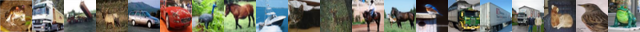

[6 9 9 4 1 1 2 7 8 3 4 7 7 2 9 9 9 3 2 6]


In [20]:
from IPython.display import display
def showX(X, rows=1):
    assert X.shape[0]%rows == 0
    int_X = ( (X+1)/2*255).clip(0,255).astype('uint8')
    # N*3072 -> N*3*32*32 -> 32 * 32N * 3
    int_X = np.moveaxis(int_X.reshape(-1,3,32,32), 1, 3)
    int_X = int_X.reshape(rows, -1, 32, 32,3).swapaxes(1,2).reshape(rows*32,-1, 3)
    display(Image.fromarray(int_X))
showX(train_X[:20])
print(train_y[:20])
# print(name_array[train_y[:20]])


In [21]:
fixed_noise = np.random.normal(size=(batchSize, nz)).astype('float32')

[0/30][100/781][0] Loss_D: 45.909233 Loss_G: 0.000000 Loss_D_real: 44.258404 Loss_D_fake: -1.650829 4.491194248199463


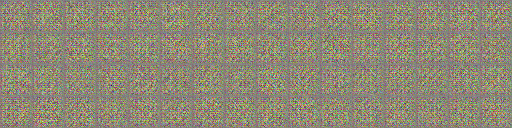

[6/30][220/781][500] Loss_D: 5.479679 Loss_G: 1.179951 Loss_D_real: 1.966750 Loss_D_fake: -3.512929 167.16799664497375


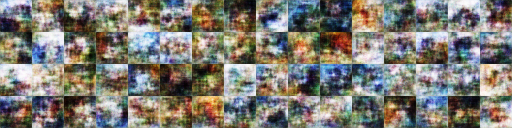

[9/30][460/781][1000] Loss_D: 5.199912 Loss_G: 1.169886 Loss_D_real: -0.844398 Loss_D_fake: -6.044311 262.9063341617584


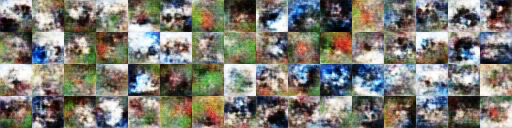

[12/30][700/781][1500] Loss_D: 4.632878 Loss_G: -0.356756 Loss_D_real: 7.165277 Loss_D_fake: 2.532398 359.8138620853424


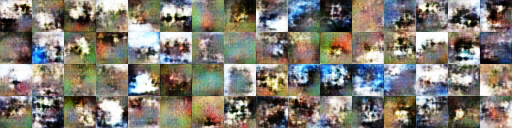

[16/30][155/781][2000] Loss_D: 3.145334 Loss_G: 2.468889 Loss_D_real: 5.401451 Loss_D_fake: 2.256116 457.09864711761475


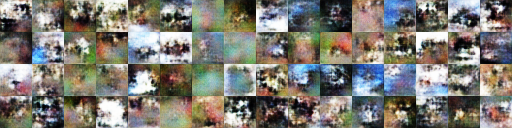

[19/30][395/781][2500] Loss_D: 4.110886 Loss_G: 0.826704 Loss_D_real: 1.152063 Loss_D_fake: -2.958822 553.725248336792


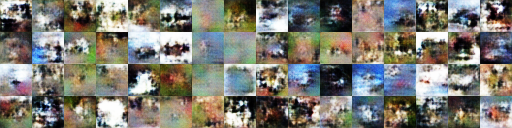

[22/30][635/781][3000] Loss_D: 3.823955 Loss_G: 3.830402 Loss_D_real: -1.014339 Loss_D_fake: -4.838293 651.3696534633636


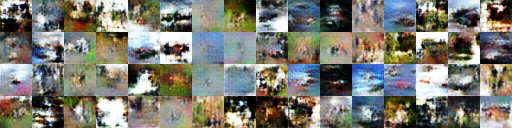

[25/30][781/781][3500] Loss_D: 2.405169 Loss_G: 0.731768 Loss_D_real: 1.070068 Loss_D_fake: -1.335102 745.0975646972656


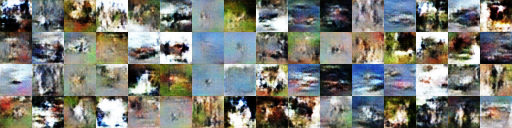

[29/30][240/781][4000] Loss_D: 2.454386 Loss_G: -0.114057 Loss_D_real: -3.335349 Loss_D_fake: -5.789734 844.7203223705292


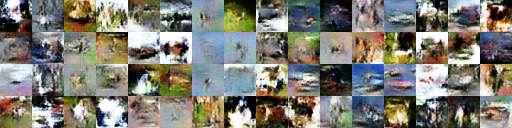

In [22]:
import time
t0 = time.time()
niter = 30
gen_iterations = 0
errG = 0
targetD = np.float32([2]*batchSize+[-2]*batchSize)[:, None]
targetG = np.ones(batchSize, dtype=np.float32)[:, None]
loss_real = []
loss_fake = []
loss_G = []
loss_D = []
for epoch in range(niter):
    i = 0
    #  每個 epoch 洗牌一下
    np.random.shuffle(train_X)
    batches = train_X.shape[0]//batchSize
    while i < batches:
        if gen_iterations < 25 or gen_iterations % 500 == 0:
            _Diters = 100
        else:
            _Diters = Diters
        j = 0
        while j < _Diters and i < batches:
            j+=1
            real_data = train_X[i*batchSize:(i+1)*batchSize]
            i+=1
            noise = np.random.normal(size=(batchSize, nz))        
            ϵ = np.random.uniform(size=(batchSize, 1, 1 ,1))        
            errD_real, errD_fake  = netD_train([real_data, noise, ϵ])
            errD = errD_real - errD_fake
            loss_real.append(errD_real)
            loss_fake.append(errD_fake)
            loss_D.append(errD)
        if gen_iterations%500==0:
            print('[%d/%d][%d/%d][%d] Loss_D: %f Loss_G: %f Loss_D_real: %f Loss_D_fake: %f'
            % (epoch, niter, i, batches, gen_iterations,errD, errG, errD_real, errD_fake), time.time()-t0)
            fake = netG.predict(fixed_noise)
            showX(fake, 4)
        
        noise = np.random.normal(size=(batchSize, nz))        
        errG, = netG_train([noise])
        loss_G.append(errG)
        gen_iterations+=1

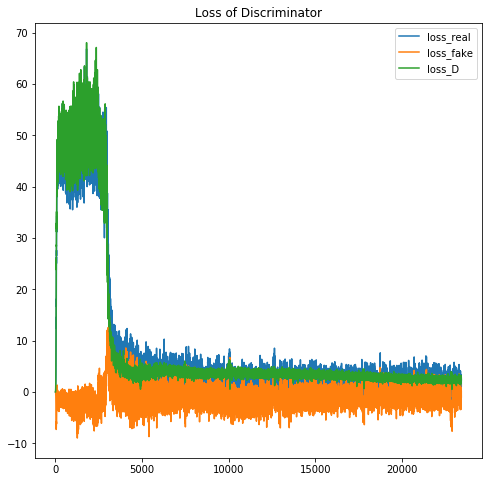

Text(0.5, 1.0, 'Loss of Generator')

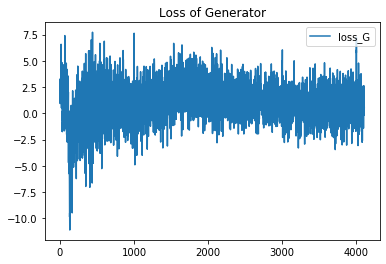

In [24]:
import matplotlib.pyplot as plt

epochs_range = range(len(loss_D))

plt.figure(figsize=(8, 8))
plt.plot(epochs_range, loss_real, label='loss_real')
plt.plot(epochs_range, loss_fake, label='loss_fake')
plt.plot(epochs_range, loss_D, label='loss_D')
plt.legend(loc='upper right')
plt.title('Loss of Discriminator')
plt.show()

plt.plot(range(len(loss_G)), loss_G, label='loss_G')
plt.legend(loc='upper right')
plt.title('Loss of Generator')
# plt.show()

# GAN

In [9]:
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, Reshape
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import cifar10
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt

import sys
import numpy as np

In [10]:
def get_generator(input_layer):

    hid= Dense(128 * 16 * 16, activation='relu')(input_layer)    
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)
    hid = Reshape((16, 16, 128))(hid)

    # adding 2 more layers
#     hid = Conv2D(128, kernel_size=5, strides=1,padding='same')(hid)
#     hid = BatchNormalization(momentum=0.9)(hid)    
#     hid = Dropout(0.5)(hid)
#     hid = LeakyReLU(alpha=0.1)(hid)
    
#     hid = Conv2D(128, kernel_size=5, strides=1,padding='same')(hid)
#     hid = BatchNormalization(momentum=0.9)(hid)    
#     hid = Dropout(0.5)(hid)
#     hid = LeakyReLU(alpha=0.1)(hid)
    
    hid = Conv2D(128, kernel_size=5, strides=1,padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)    
#     hid = Dropout(0.5)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)
 
    hid = Conv2DTranspose(128, 4, strides=2, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
#     hid = Dropout(0.5)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Conv2D(128, kernel_size=5, strides=1, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
#     hid = Dropout(0.5)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Conv2D(3, kernel_size=5, strides=1, padding="same")(hid)
    out = Activation("tanh")(hid)

    model = Model(input_layer, out)
    model.summary()
    return model, out

In [11]:
def get_discriminator(input_layer):
    hid = Conv2D(128, kernel_size=3, strides=1, padding='same')(input_layer)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

#     hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
#     hid = BatchNormalization(momentum=0.9)(hid)
#     hid = LeakyReLU(alpha=0.1)(hid)

#     hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
#     hid = BatchNormalization(momentum=0.9)(hid)
#     hid = LeakyReLU(alpha=0.1)(hid)
    
    hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Conv2D(128, kernel_size=4, strides=2, padding='same')(hid)
    hid = BatchNormalization(momentum=0.9)(hid)
    hid = LeakyReLU(alpha=0.1)(hid)

    hid = Flatten()(hid)
    hid = Dropout(0.4)(hid)
    out = Dense(1, activation='sigmoid')(hid)

    model = Model(input_layer, out)

    model.summary()

    return model, out

In [18]:
from tensorflow.keras.preprocessing import image

def generate_noise(n_samples, noise_dim):
    X = np.random.normal(0, 1, size=(n_samples, noise_dim))
    return X

def show_imgs(batchidx):
    noise = generate_noise(9, 500) # 100 to 200 or 500
    gen_imgs = generator.predict(noise)

    fig, axs = plt.subplots(3, 3)
    count = 0
    for i in range(3):
        for j in range(3):
          # Dont scale the images back, let keras handle it
            img = image.array_to_img(gen_imgs[count], scale=True)
            axs[i,j].imshow(img)
            axs[i,j].axis('off')
            count += 1
    plt.show()
    plt.close()

In [19]:
img_input = Input(shape=(32,32,3))
discriminator, disc_out = get_discriminator(img_input)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

discriminator.trainable = False

noise_input = Input(shape=(500,)) # 100 to 200 or 500
generator, gen_out = get_generator(noise_input)

gan_input = Input(shape=(500,))
x = generator(gan_input)
gan_out = discriminator(x)
gan = Model(gan_input, gan_out)
gan.summary()

gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 32, 32, 128)       3584      
_________________________________________________________________
batch_normalization_18 (Batc (None, 32, 32, 128)       512       
_________________________________________________________________
leaky_re_lu_18 (LeakyReLU)   (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 16, 16, 128)       262272    
_________________________________________________________________
batch_normalization_19 (Batc (None, 16, 16, 128)       512       
_________________________________________________________________
leaky_re_lu_19 (LeakyReLU)   (None, 16, 16, 128)       0   

In [14]:
BATCH_SIZE = 16

# # Get training images
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# Select Cars
X_train = X_train[y_train[:,0]==1]
print ("Training shape: {}".format(X_train.shape))

# Normalize data
X_train = (X_train - 127.5) / 127.5
 
num_batches = int(X_train.shape[0]/BATCH_SIZE)

Training shape: (5000, 32, 32, 3)


  Epoch: 1, Generator Loss: 1.368418855109037, Discriminator Loss: [0.30914047 0.        ]


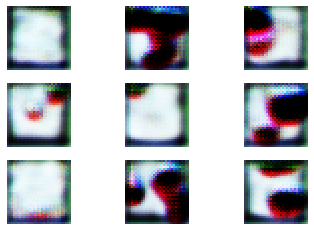

  Epoch: 2, Generator Loss: 1.9168460168517554, Discriminator Loss: [0.32306787 0.        ]


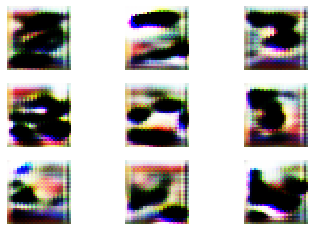

  Epoch: 3, Generator Loss: 1.625853484759155, Discriminator Loss: [0.36551243 0.        ]


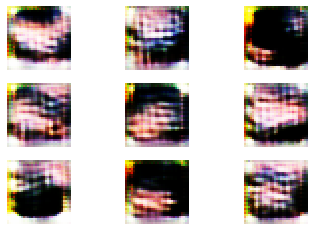

  Epoch: 4, Generator Loss: 1.5778637081026459, Discriminator Loss: [0.34965903 0.        ]


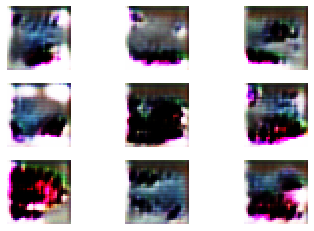

  Epoch: 5, Generator Loss: 1.482445411061725, Discriminator Loss: [0.37144634 0.        ]


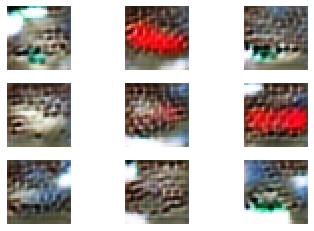

  Epoch: 6, Generator Loss: 1.8092993265137267, Discriminator Loss: [0.38024005 0.        ]


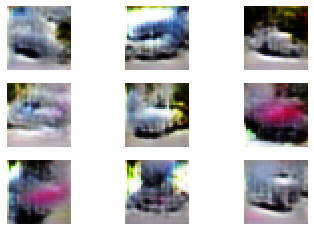

  Epoch: 7, Generator Loss: 1.574563347089749, Discriminator Loss: [0.3997868 0.       ]


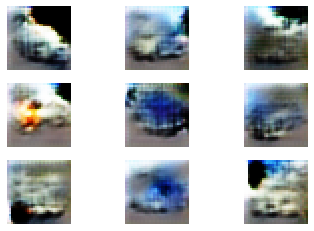

  Epoch: 8, Generator Loss: 1.7087352676555896, Discriminator Loss: [0.4067047 0.       ]


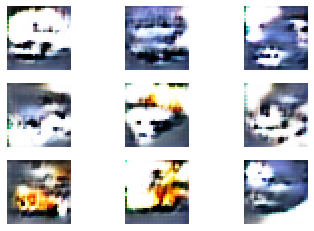

  Epoch: 9, Generator Loss: 1.4507181099735391, Discriminator Loss: [0.43971992 0.        ]


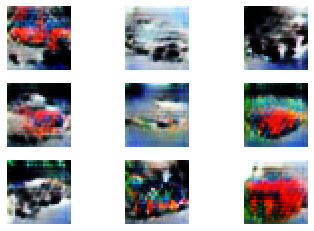

  Epoch: 10, Generator Loss: 1.5775929699914577, Discriminator Loss: [0.42313161 0.        ]


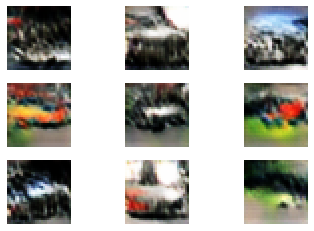

In [20]:
N_EPOCHS = 10
loss_D = []
loss_G = []
jsd = []
for epoch in range(N_EPOCHS):

    cum_d_loss = 0.
    cum_g_loss = 0.
  
    for batch_idx in range(num_batches):
        # Get the next set of real images to be used in this iteration
        images = X_train[batch_idx*BATCH_SIZE : (batch_idx+1)*BATCH_SIZE]

        noise_data = generate_noise(BATCH_SIZE, 500) #100 to 200 or 500
        generated_images = generator.predict(noise_data)

        # Train on soft labels (add noise to labels as well)
        noise_prop = 0.05 # Randomly flip 5% of labels

        # Prepare labels for real data
        true_labels = np.zeros((BATCH_SIZE, 1)) + np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
        flipped_idx = np.random.choice(np.arange(len(true_labels)), size=int(noise_prop*len(true_labels)))
        true_labels[flipped_idx] = 1 - true_labels[flipped_idx]

        # Train discriminator on real data
        d_loss_true = discriminator.train_on_batch(images, true_labels)

        # Prepare labels for generated data
        gene_labels = np.ones((BATCH_SIZE, 1)) - np.random.uniform(low=0.0, high=0.1, size=(BATCH_SIZE, 1))
        flipped_idx = np.random.choice(np.arange(len(gene_labels)), size=int(noise_prop*len(gene_labels)))
        gene_labels[flipped_idx] = 1 - gene_labels[flipped_idx]

        # Train discriminator on generated data
        d_loss_gene = discriminator.train_on_batch(generated_images, gene_labels)
        
        d_loss = 0.5 * np.add(d_loss_true, d_loss_gene)
        cum_d_loss += d_loss

        # Train generator
        noise_data = generate_noise(BATCH_SIZE, 500) # increase the dimension from 100 to 200 or 500
        g_loss = gan.train_on_batch(noise_data, np.zeros((BATCH_SIZE, 1)))
        jsd.append(g_loss)
        cum_g_loss += g_loss

    print('  Epoch: {}, Generator Loss: {}, Discriminator Loss: {}'.format(epoch+1, cum_g_loss/num_batches, cum_d_loss/num_batches))
    show_imgs("epoch" + str(epoch))
    loss_D.append(cum_d_loss/num_batches)
    loss_G.append(cum_g_loss/num_batches)

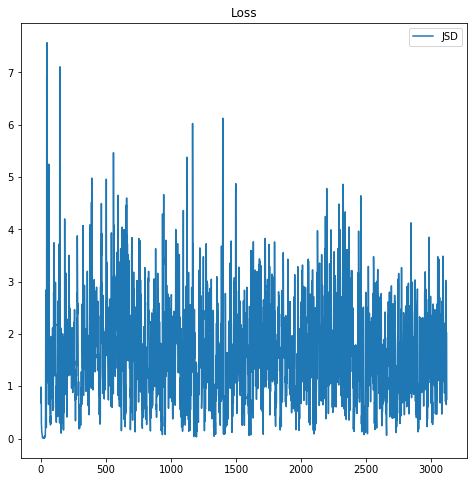

In [21]:
import matplotlib.pyplot as plt

epochs_range = range(len(loss_D))

plt.figure(figsize=(8, 8))

# plt.plot(epochs_range, loss_D, label='loss_D')
plt.plot(range(len(jsd)), jsd, label='JSD')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

# VAE

In [5]:
from tensorflow.keras.layers import Input,Flatten,Dense,Conv2D, Lambda, Reshape,Conv2DTranspose
from tensorflow.keras import Model,Sequential
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.losses import mse, binary_crossentropy
from tensorflow.keras.layers import Layer
from tensorflow.keras import metrics
from tensorflow.keras.datasets import cifar10


In [46]:
img_rows, img_cols, img_chns = 32, 32, 3
latent_dim = 5
intermediate_dim = 128
epsilon_std = 1
epochs = 50
filters = 20
num_conv = 3
batch_size = 256

In [47]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pickle


# # import parameters
# from cifar10_params import *

# tensorflow uses channels_last
# theano uses channels_first
if K.image_data_format() == 'channels_first':
    original_img_size = (img_chns, img_rows, img_cols)
else:
    original_img_size = (img_rows, img_cols, img_chns)


# encoder architecture
x = Input(shape=original_img_size)
conv_1 = Conv2D(img_chns,
                kernel_size=(2, 2),
                padding='same', activation='relu')(x)
conv_2 = Conv2D(filters,
                kernel_size=(2, 2),
                padding='same', activation='relu',
                strides=(2, 2))(conv_1)
conv_3 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_2)
conv_4 = Conv2D(filters,
                kernel_size=num_conv,
                padding='same', activation='relu',
                strides=1)(conv_3)
flat = Flatten()(conv_4)
hidden = Dense(intermediate_dim, activation='relu')(flat)

# mean and variance for latent variables
z_mean = Dense(latent_dim)(hidden)
z_log_var = Dense(latent_dim)(hidden)

# sampling layer
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon
#     z_mean, z_log_var = args
#     epsilon = K.random_normal(shape=(K.int_shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
#     return z_mean + K.exp(z_log_var) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

In [48]:
# decoder architecture
decoder_hid = Dense(intermediate_dim, activation='relu')
decoder_upsample = Dense(filters * (img_rows / 2) * (img_cols / 2), activation='relu')
# decoder_upsample = Dense(32 * 16 * 16, activation='relu')


if K.image_data_format() == 'channels_first':
    output_shape = (batch_size, filters, img_rows / 2, img_cols / 2)
else:
    output_shape = (batch_size, int(img_rows / 2), int(img_cols / 2), filters)

decoder_reshape = Reshape(output_shape[1:])
decoder_deconv_1 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_2 = Conv2DTranspose(filters,
                                   kernel_size=num_conv,
                                   padding='same',
                                   strides=1,
                                   activation='relu')
decoder_deconv_3_upsamp = Conv2DTranspose(filters,
                                          kernel_size=(3, 3),
                                          strides=(2, 2),
                                          padding='valid',
                                          activation='relu')
decoder_mean_squash = Conv2D(img_chns,
                             kernel_size=2,
                             padding='valid',
                             activation='sigmoid')

hid_decoded = decoder_hid(z)
up_decoded = decoder_upsample(hid_decoded)
reshape_decoded = decoder_reshape(up_decoded)
deconv_1_decoded = decoder_deconv_1(reshape_decoded)
deconv_2_decoded = decoder_deconv_2(deconv_1_decoded)
x_decoded_relu = decoder_deconv_3_upsamp(deconv_2_decoded)
x_decoded_mean_squash = decoder_mean_squash(x_decoded_relu)


In [49]:
# Custom loss layer

class CustomVariationalLayer(Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(CustomVariationalLayer, self).__init__(**kwargs)

    def vae_loss(self, x, x_decoded_mean_squash):
        x = K.flatten(x)
        x_decoded_mean_squash = K.flatten(x_decoded_mean_squash)
        xent_loss = img_rows * img_cols * metrics.binary_crossentropy(x, x_decoded_mean_squash)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        x_decoded_mean_squash = inputs[1]
        loss = self.vae_loss(x, x_decoded_mean_squash)
        self.add_loss(loss, inputs=inputs)
        return x

y = CustomVariationalLayer()([x, x_decoded_mean_squash])



In [50]:
# entire model
vae = Model(x, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()


# load dataset
(x_train, _), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)


# training
history = vae.fit(x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

# encoder from learned model
encoder = Model(x, z_mean)

# generator / decoder from learned model
decoder_input = Input(shape=(latent_dim,))
_hid_decoded = decoder_hid(decoder_input)
_up_decoded = decoder_upsample(_hid_decoded)
_reshape_decoded = decoder_reshape(_up_decoded)
_deconv_1_decoded = decoder_deconv_1(_reshape_decoded)
_deconv_2_decoded = decoder_deconv_2(_deconv_1_decoded)
_x_decoded_relu = decoder_deconv_3_upsamp(_deconv_2_decoded)
_x_decoded_mean_squash = decoder_mean_squash(_x_decoded_relu)
generator = Model(decoder_input, _x_decoded_mean_squash)

# save all 3 models for future use - especially generator
vae.save('../models/cifar10_ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (latent_dim, num_conv, intermediate_dim, epochs))
encoder.save('../models/cifar10_ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (latent_dim, num_conv, intermediate_dim, epochs))
generator.save('../models/cifar10_ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (latent_dim, num_conv, intermediate_dim, epochs))

# save training history
fname = '../models/cifar10_ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (latent_dim, num_conv, intermediate_dim, epochs)
with open(fname, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 32, 32, 3)    39          input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 16, 16, 20)   260         conv2d_24[0][0]                  
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 16, 16, 20)   3620        conv2d_25[0][0]                  
___________________________________________________________________________________________

{'loss': [672.7736885351562, 646.2746770117187, 641.3098948828125, 639.1374508984375, 637.8454719335938, 636.9448216796875, 636.30371453125, 635.7637426171875, 635.3141095117187, 634.9473743945313, 634.6012742578125, 634.2881817382812, 633.9593676171875, 633.5608387890625, 633.2115620898437, 632.91973828125, 632.6274008007813, 632.4070778320313, 632.2028630078125, 632.0198721484375, 631.8304192773437, 631.7229735546875, 631.5660034765625, 631.4283705078125, 631.3038304101563, 631.1894422070312, 631.0476388867188, 630.9474887109375, 630.8457043359375, 630.7317930078125, 630.6378936328125, 630.5387564257812, 630.435070703125, 630.3629474023437, 630.2448188085938, 630.1932027734375, 630.0563405859375, 629.9979109570312, 629.9041065820312, 629.7862873828125, 629.7545073242187, 629.6685453515626, 629.5905128515625, 629.5229521875, 629.4382568554687, 629.3592340625, 629.3079568359375, 629.2446700195312, 629.1767975195313, 629.1071609765625], 'val_loss': [655.3007490234374, 645.2478415039062,

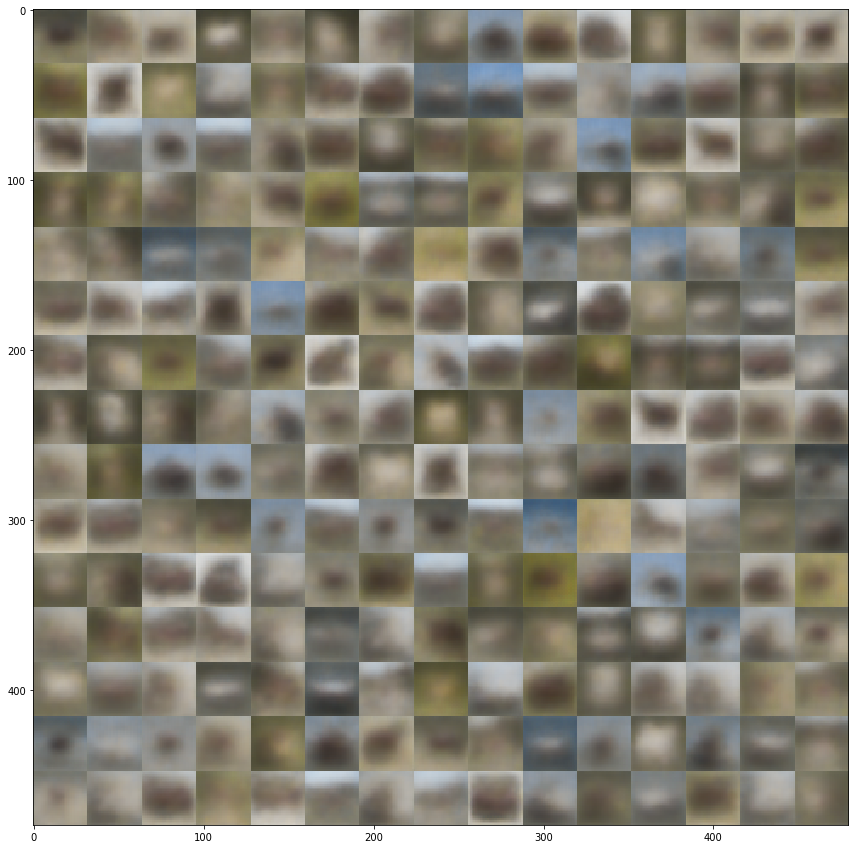

In [51]:

# load saved models
vae = tf.keras.models.load_model('../models/cifar10_ld_%d_conv_%d_id_%d_e_%d_vae.h5' % (latent_dim, num_conv, intermediate_dim, epochs),
    custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'CustomVariationalLayer':CustomVariationalLayer})
encoder = tf.keras.models.load_model('../models/cifar10_ld_%d_conv_%d_id_%d_e_%d_encoder.h5' % (latent_dim, num_conv, intermediate_dim, epochs),
    custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'CustomVariationalLayer':CustomVariationalLayer})
generator = tf.keras.models.load_model('../models/cifar10_ld_%d_conv_%d_id_%d_e_%d_generator.h5' % (latent_dim, num_conv, intermediate_dim, epochs),
    custom_objects={'latent_dim':latent_dim, 'epsilon_std':epsilon_std, 'CustomVariationalLayer':CustomVariationalLayer})

# load history if saved
fname = '../models/cifar10_ld_%d_conv_%d_id_%d_e_%d_history.pkl' % (latent_dim, num_conv, intermediate_dim, epochs)
try:
    with open(fname, 'rb') as fo:
        history = pickle.load(fo)
    print (history)
except:
    print ("training history not saved")



# load dataset to plot latent space
(x_train, _), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0],) + original_img_size)
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape((x_test.shape[0],) + original_img_size)

n = 15
img_size = 32
figure = np.zeros((img_size * n, img_size * n, img_chns))

for i in range(n):
    for j in range(n):
        z_sample = np.array([np.random.uniform(-1,1 ,size=latent_dim)])
        x_decoded = generator.predict(z_sample)
        img = x_decoded[0].reshape(img_size, img_size, img_chns)
        figure[i * img_size: (i + 1) * img_size,j * img_size: (j + 1) * img_size] = img

plt.figure(figsize=(15, 15))
plt.imshow(figure, cmap='Greys_r')
plt.show()

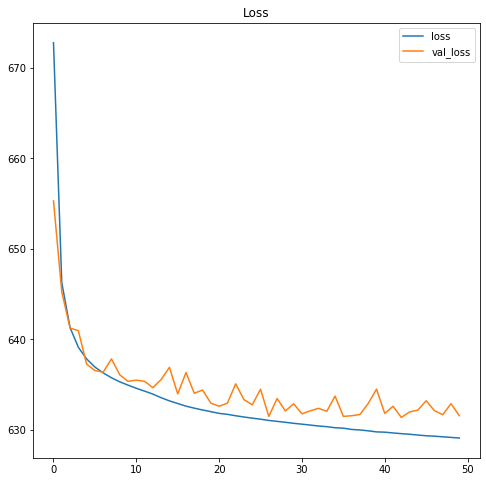

In [52]:
# dim = 2 20filter  
plt.figure(figsize=(8, 8))
loss = history['loss']
# plt.plot(epochs_range, loss_D, label='loss_D')
plt.plot(range(epochs), loss, label='loss')
plt.plot(range(epochs), history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

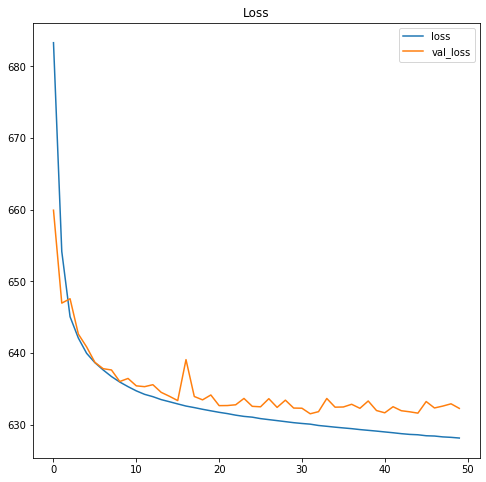

In [37]:
# dim = 5 128
plt.figure(figsize=(8, 8))
loss = history['loss']
# plt.plot(epochs_range, loss_D, label='loss_D')
plt.plot(range(epochs), loss, label='loss')
plt.plot(range(epochs), history['val_loss'], label='val_loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()